In [ ]:
!pip install -q transformers datasets accelerate

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My\ Drive/NLP

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/NLP


In [ ]:
from datasets import load_dataset, Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import torch
import numpy as np
import pickle
import random
import matplotlib.pyplot as plt

import pandas as pd
from pandas.core.common import flatten

import gensim
from gensim.models.word2vec import Word2Vec
from gensim.test.utils import datapath
import re

# Optional, fix randomness
seed = 42
random.seed(seed)

# Use GPU instead of CPU if possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type != 'cuda':
    raise SystemError('GPU device not found')

In [ ]:
# Load the dataset
dataset = load_dataset("Open-Orca/SlimOrca")
dataset.set_format("torch")

dataset

DatasetDict({
    train: Dataset({
        features: ['conversations'],
        num_rows: 517982
    })
})

# Preliminary Analysis

## Our Dataset: OpenOrca-SlimOrca

The dataset we used contains around 500000 conversations between a human and ChatGPT/GPT-4.
These conversations are made of a question by a human and the response from the model.

It is formed by triples containing:
- System message
- User query
- GPT response

It contains a large variety of prompts. They have different types of queries, topics and lenghts.

We parse the dataset to make the documents easier to read and analyze

In [ ]:
def parse_dataset(data):
    documents = []

    for conv in data:

        doc = ""
        if conv[0]['from'] == 'system':
            doc += "system:\n" + conv[0]["value"]
            doc += "\n\nhuman:\n" + conv[1]["value"]
            doc += "\n\ngpt:\n" + conv[2]["value"]
        else:
            # A few documents do not have a system message, so we need to check
            doc += "system:\n"
            doc += "\n\nhuman:\n" + conv[0]["value"]
            doc += "\n\ngpt:\n" + conv[1]["value"]

        documents.append(doc)

    return documents

documents = parse_dataset(dataset["train"]["conversations"])

Here is an example of a document

In [ ]:
print(documents[2])

system:
You are an AI assistant. You will be given a task. You must generate a detailed and long answer.

human:
Produce a long descriptive sentence that uses all these words: Albuquerque, New Mexico, areaOfLand, 486.2 (square kilometres); Albuquerque, New Mexico, populationDensity, 1142.3 (inhabitants per square kilometre); Albuquerque, New Mexico, isPartOf, Bernalillo County, New Mexico; Albuquerque, New Mexico, areaTotal, 490.9 (square kilometres)

gpt:
Stretching across a vast areaOfLand, totaling 486.2 square kilometres, Albuquerque, New Mexico, boasts a thriving populationDensity of approximately 1142.3 inhabitants per square kilometre, all residing within the expansive city limits which are part of the beautiful Bernalillo County in New Mexico, enveloping an impressive areaTotal of 490.9 square kilometres, encompassing both natural and urban landscapes.


We show some statistics about the documents in the dataset.

In [ ]:
length = []
vocab_size = []
for doc in documents:
    words = doc.split()
    length.append(len(words))
    vocab_size.append(len(set(words)))

avg_length = np.average(length)
avg_vocab_size = np.average(vocab_size)

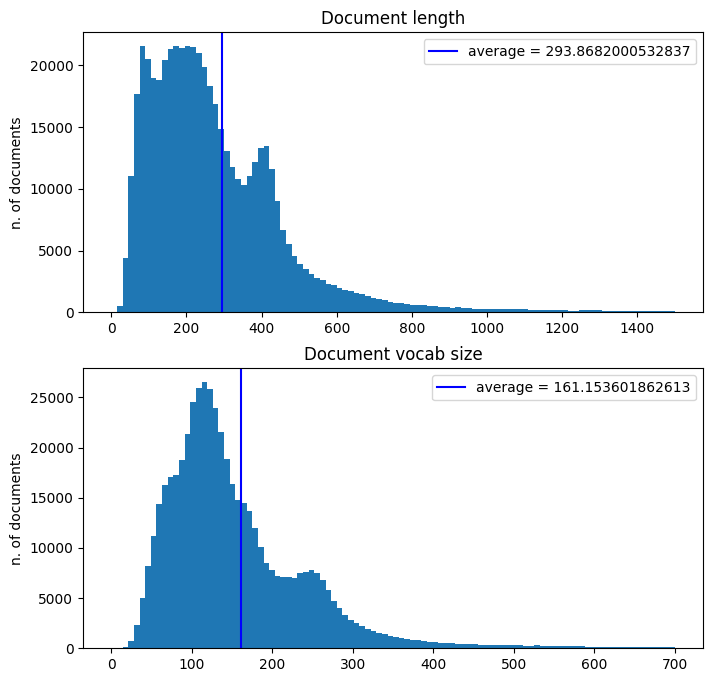

In [ ]:
fig, axes = plt.subplots(2, 1, figsize = (8, 8))
axes = axes.flatten()

axes[0].set_title("Document length")
axes[0].hist(length, bins = 100, range = (0, 1500))
axes[0].set_ylabel("n. of documents")
axes[0].axvline(avg_length, label = f"average = {avg_length}", c = 'b')
axes[0].legend()

axes[1].set_title("Document vocab size")
axes[1].hist(vocab_size, bins = 100, range = (0, 700))
axes[1].set_ylabel("n. of documents")
axes[1].axvline(avg_vocab_size, label = f"average = {avg_vocab_size}", c = 'b')
axes[1].legend()

plt.show()

## Clustering

To help us analyze the conversations we apply clustering techiques to the dataset. This will help us unterstand what type of queries are made, or the topics they talk about.

First we remove the system messages before applying vectorization.
There are only 13 system messages repeated throughout the dataset. When we tried to perform clustering a lot of clusters would just look for the words in these prompts. This does not help up understand what is in the dataset and we achieved much better results be removing them.

In [ ]:
def parse_documents(data):
    documents = []

    for conv in data:

        doc = ""
        if conv[0]['from'] == 'system':
            # doc += "system:\n" + conv[0]["value"]
            doc += "\n\nhuman:\n" + conv[1]["value"]
            doc += "\n\ngpt:\n" + conv[2]["value"]
        else:
            # doc += "system:\n"
            doc += "\n\nhuman:\n" + conv[0]["value"]
            doc += "\n\ngpt:\n" + conv[1]["value"]

        documents.append(doc)

    return documents

documents = parse_documents(dataset["train"]["conversations"])

We vectorize the documents with tf-idf.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_df=0.8, min_df=5, stop_words='english')

In [ ]:
tfidf_vectorizer.fit(documents)

TfidfVectorizer(max_df=0.8, min_df=5, stop_words='english')

In [ ]:
vocab = tfidf_vectorizer.get_feature_names_out()
print(f"Length of vocabulary: {len(vocab)}")

Length of vocabulary: 148450


In [ ]:
vector_documents = tfidf_vectorizer.transform(documents)

We chose to do an iniztial clustering with Kmeans, since it is faster than other methods, but still provides interesting results.

We don't know how many clusters we need, so we perform elbow analysis to decite the value for k.
To do this i used MiniBatchKmeans, reducing the time required drastically with a small price in accuracy.

In [ ]:
from sklearn.cluster import KMeans, MiniBatchKMeans

In [ ]:
performance = []
for k in range(1, 100):
    performance.append(MiniBatchKMeans(n_clusters=k, batch_size=5000).fit(vector_documents).inertia_)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


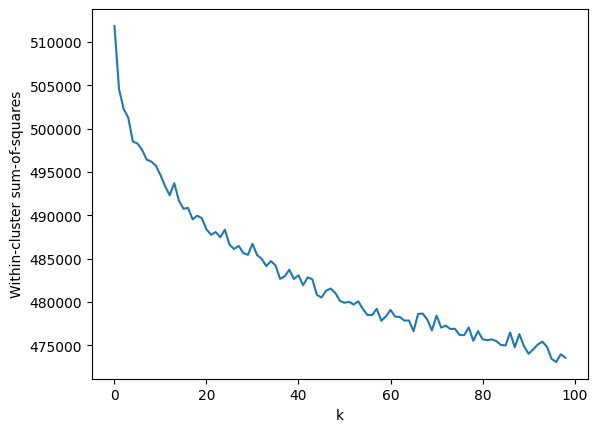

In [ ]:
plt.figure()
plt.plot(performance)
plt.ylabel('Within-cluster sum-of-squares')
plt.xlabel('k')
plt.show()

We can see that the WSS goes down quickly at first and then slows down, but never really reaches a plateau. There are no obvious elbows in the graph.
This is most likealy because the conversations are very general in type and topic, they are not divided in a set number of categories. This means that we can keep dividing into more clusters, making the division more specific.

This being said we decided to choose k = 40 for the final clustering. It seems a nice balance looking at the graph.

In [ ]:
k = 40

kmeans = KMeans(n_clusters=k, verbose=1, max_iter=100, n_init=5)
kmeans.fit(vector_documents)

Initialization complete
Iteration 0, inertia 922623.2339396636.
Iteration 1, inertia 491722.1184316786.
Iteration 2, inertia 485208.35428679525.
Iteration 3, inertia 483928.38818206487.
Iteration 4, inertia 483377.64664794004.
Iteration 5, inertia 483028.28851684474.
Iteration 6, inertia 482753.8795950631.
Iteration 7, inertia 482587.9840249319.
Iteration 8, inertia 482382.4172457395.
Iteration 9, inertia 482218.77603605564.
Iteration 10, inertia 482154.2962121115.
Iteration 11, inertia 482124.25814312405.
Iteration 12, inertia 482098.3019004105.
Iteration 13, inertia 482076.38216038764.
Iteration 14, inertia 482051.25372471707.
Iteration 15, inertia 482027.26708572096.
Iteration 16, inertia 482003.1555253122.
Iteration 17, inertia 481984.55510509625.
Iteration 18, inertia 481973.6831508967.
Iteration 19, inertia 481963.3684123587.
Iteration 20, inertia 481952.38776030706.
Iteration 21, inertia 481936.07639712445.
Iteration 22, inertia 481903.49017085944.
Iteration 23, inertia 481872.5

KMeans(max_iter=100, n_clusters=40, n_init=5, verbose=1)

In [ ]:
from sklearn import metrics

print("Intrinsic evaluation measures:")
print("Within-cluster sum-of-squares:", str(kmeans.inertia_))
#print("Silhouette coefficient:", str(metrics.silhouette_score(vector_documents, kmeans.labels_)))

Intrinsic evaluation measures:
Within-cluster sum-of-squares: 480922.3465499818


In [ ]:
# Save/Load the model to avoid having to fit again if not necessary

# with open("Models/KMeans/kmeans.pkl", "wb") as f:
#     pickle.dump(kmeans, f)

# with open("Models/KMeans/kmeans.pkl", "rb") as f:
#     kmeans = pickle.load(f)

Here are the resulting clusters.

For each cluster we display the number of documents and the 10 most important terms.

In [ ]:
print("Top terms per cluster:")
vocab = tfidf_vectorizer.get_feature_names_out()

for i in range(kmeans.n_clusters):
    centroid = kmeans.cluster_centers_[i]
    sorted_terms = centroid.argsort()[::-1]
    print(f"Cluster {i}:\tn: {sum(kmeans.labels_ == i)}  \t{[vocab[j] for j in sorted_terms[:10]]}")

Top terms per cluster:
Cluster 0:	n: 15520  	['blood', 'food', 'body', 'plants', 'cells', 'answer', 'species', 'animals', 'question', 'health']
Cluster 1:	n: 16714  	['premise', 'hypothesis', 'entailed', 'step', 'possible', 'man', 'tell', 'information', 'true', 'yes']
Cluster 2:	n: 10738  	['english', 'sentence', 'translation', 'translate', 'task', 'language', 'given', 'japanese', 'input', 'translated']
Cluster 3:	n: 14735  	['premise', 'hypothesis', 'tell', 'possible', 'yes', 'man', 'entailed', 'options', 'answer', 'woman']
Cluster 4:	n: 24866  	['movie', 'film', 'plot', 'answer', 'question', 'following', 'title', 'father', 'story', 'man']
Cluster 5:	n: 7828  	['restaurant', 'food', 'rating', 'customer', 'riverside', 'eattype', 'data', 'pricerange', 'sentence', 'familyfriendly']
Cluster 6:	n: 20398  	['sentence', 'sentences', 'step', 'words', 'sense', 'second', 'given', 'task', 'subject', 'word']
Cluster 7:	n: 13369  	['tell', 'possible', 'yes', 'man', 'premise', 'options', 'hypothesi

We can check the document closest to the centroid of a cluster to get a good example of a document in a specific cluster.

In [ ]:
# Get the centroid for the first cluster
centroid = kmeans.cluster_centers_[3]

# Sort terms according to their weights
# (argsort goes from lowest to highest, we reverse the order through slicing)
sorted_terms = centroid.argsort()[::-1]

# Print out the top 10 terms for the cluster
print([vocab[j] for j in sorted_terms[:10]])

# Find and print the closest document
index = np.argmax([np.dot(centroid,vec.toarray()[0,:]) for vec in vector_documents])
print(documents[index])

['premise', 'hypothesis', 'tell', 'possible', 'yes', 'man', 'entailed', 'options', 'answer', 'woman']


human:
[QUESTION] Test for natural language inference.
Premise: "A man dances on a colorful wall."
Hypothesis: "Man  having lunch in a restaurant."
Is the hypothesis entailed by the premise?
Options:
- yes
- no
- it is not possible to tell
A man cannot dance on a wall at the same time he is having lunch in a restaurant.
The answer is no.
Q: Premise: "A man in an orange shirt is gathering clay."
Based on this premise, can we conclude that the hypothesis "In a clay pit." is true?
Options:
- yes
- it is not possible to tell
- no
A: A man sits on a horse at the top of a high ridge.
The answer is no.
QUESTION: Premise: "A person standing on a stage in front of a seated crowd."
Hypothesis: "Someone is standing on stage in front of a crowd."
Is the hypothesis entailed by the premise?
Options:
- yes
- it is not possible to tell
- no

Let's solve it slowly: A person standing on a stage can be

## Extracting topics using LDA

The KMeans clustering provided interesting results, but it also had a couple of issues:
- Some of the clusters don't seem to make too much sense
- Some of the clusters include conversations about certain topics, while others are divided based on the type of query. These two aren't mutually exclusive, a document con technically be part of multiple clusters.

We think using LDA could help solve both of these issues and provide us with a better understanding of the dataset.

First we split the dataset in two parts, one used for LDA and one we will use later to test it. We will also use it to train a TSNE model to visualize the data.

In [ ]:
from sklearn.model_selection import train_test_split

documents_train, documents_test = train_test_split(documents, test_size=0.1)
print('No. training docs:', len(documents_train))
print('No. testing docs:', len(documents_test))

No. training docs: 466183
No. testing docs: 51799


We need to vectorize the data using a CountVectorizer when using LDA.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words='english',min_df=5,max_df=.5)
vector_documents_train = vectorizer.fit_transform(documents_train)

In [ ]:
vocab = vectorizer.get_feature_names_out()
len(vocab)

139571

We decided to use 40 for the number of topics, following the same reasoning that we made when deciding k for KMeans. Doing the same analysis with LDA would have taken far too long and would most likely reach a similar conclusion.

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=40, verbose=3, learning_method='online', max_iter=10, batch_size=2024)
lda.fit(vector_documents_train)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


LatentDirichletAllocation(batch_size=2024, learning_method='online',
                          n_components=40, verbose=3)

In [ ]:
# Save/Load the model to avoid having to fit again if not necessary

# with open("Models/KMeans/lda.pkl", "wb") as f:
#     pickle.dump(lda, f)

# with open("Models/KMeans/lda.pkl", "rb") as f:
#     lda = pickle.load(f)

In [ ]:
vector_documents_test = vectorizer.transform(documents_test)
lda.perplexity(vector_documents_test)

5096.508508408996

Here are the resulting topics, with the 10 most imoportant terms for each.

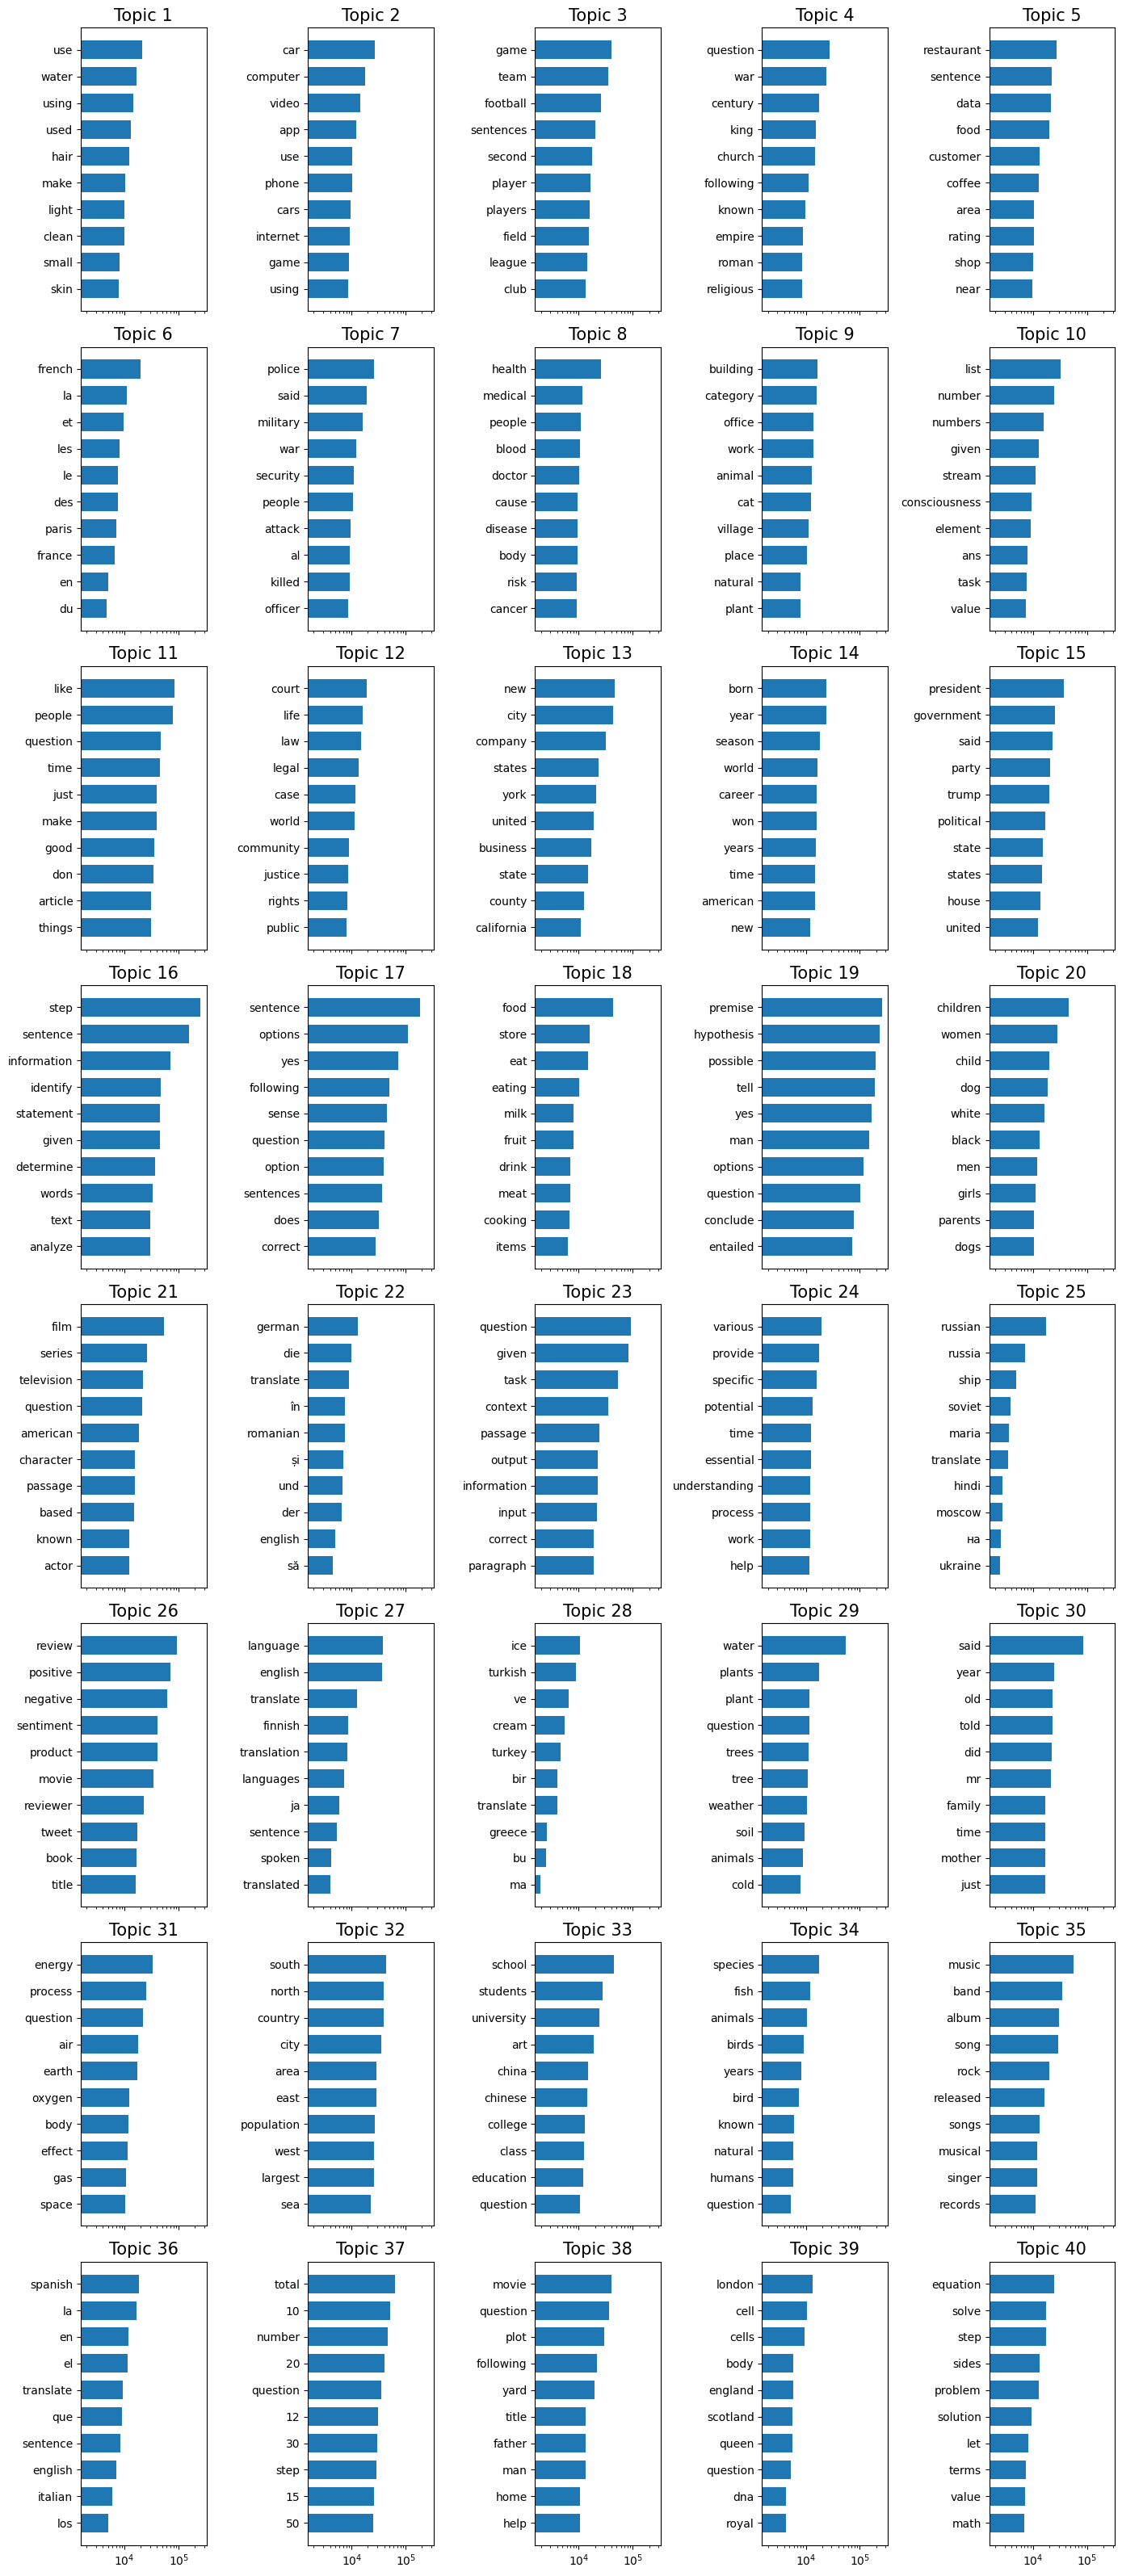

In [ ]:
num_words = 10
cols = 5
rows = int(len(lda.components_)/5)

fig, axes = plt.subplots(rows, cols, figsize=(14, 4 * rows), sharex=True)
axes = axes.flatten()
for topic_idx, topic in enumerate(lda.components_):
    top_terms_index = topic.argsort()[:-num_words - 1:-1]
    top_terms = [vocab[i] for i in top_terms_index]
    weights = topic[top_terms_index]
    ax = axes[topic_idx]
    ax.barh(top_terms, weights, height=0.7)
    ax.set_title(f'Topic {topic_idx +1}',fontdict={'fontsize': 15})
    ax.invert_yaxis()
    ax.set_xscale('log')

plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
plt.tight_layout()
plt.show()

We can use the trained model to show the topics of any document.

In [ ]:
doc = documents_test[935]

print(doc)



human:
In this task you will be given two lists of numbers and you need to calculate the intersection between these two lists. The intersection between two lists is another list where every element is common between the two original lists. If there are no elements in the intersection, answer with an empty list. Your list of numbers must be inside brackets. Sort the numbers in your answer in an ascending order, that is, no matter what the order of the numbers in the lists is, you should put them in your answer in an ascending order.

[6, 9, 8, 1, 8, 4, 4, 3, 3, 1] , [7, 5, 5, 5, 3, 1, 4, 3, 8, 5]

gpt:
The intersection of the two lists is: [1, 3, 4, 8]


In [ ]:
doc_vec = vectorizer.transform([doc])[0]
topic_vec = lda.transform(doc_vec)[0]

sorted_topics = topic_vec.argsort()[::-1]
sorted_prevalence = sorted(topic_vec)[::-1]

for i in range(10):
    if sorted_prevalence[i] < .01: break
    topic = sorted_topics[i]
    sorted_terms = np.flip(lda.components_[topic].argsort())
    print (f'{100 * sorted_prevalence[i]:.1f}% Topic {topic + 1}:\t{" ".join(vocab[i] for i in sorted_terms[:10])}')

97.2% Topic 10:	list number numbers given stream consciousness element ans task value


## Visualizing with t-SNE

We take the transformed dataset from the LDA and we use t-SNE to reduce from 40 to 2 dimentions. This allows us to visualize the dataset.

To do this we use the test portion of the dataset. The visualized data isn't the same used to train the LDA model.

In [ ]:
from sklearn.manifold import TSNE

tsne_embedding = TSNE(n_components=2).fit_transform(lda.transform(vector_documents_test))
tsne_embedding.shape

(51799, 2)

In [ ]:
[x, y] = np.transpose(tsne_embedding)

Here is the resulting graph:

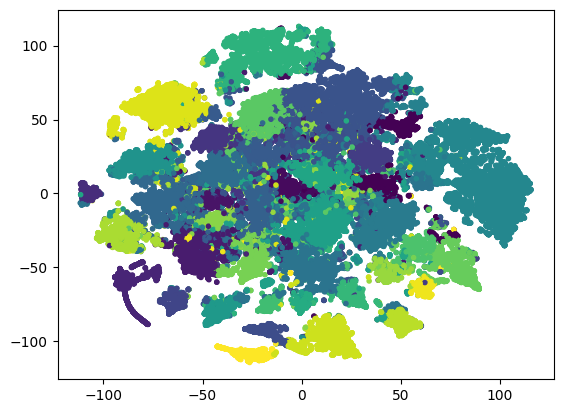

In [ ]:
freq_topic = [topic_vec.argsort()[-1] for topic_vec in lda.transform(vector_documents_test)]

colors = plt.get_cmap('rainbow', 40)

plt.scatter(x, y, c=freq_topic, marker='.')

We can see that the LDA worked pretty well.

The clusters are well defined, with some overlaps mostly concentrated around the middle. Some topics are larger than others and some are more isolated. On the sides we can see that some topics are completely separated from the rest.

## Further analysis with Word2Vec

We trained a Word2Vec model on our dataset. Looking at the resulting embedding could help us understand the data better, in particular some relationships between words.

First we have to prepare the dataset:

In [ ]:
# Flatten the conversations to simplify analysis
conversations = [conv for sublist in dataset['conversations'] for conv in sublist]
df = pd.DataFrame(conversations)

# Assuming 'value' holds the text of each utterance
texts = df['value'].tolist()

del conversations
# del dataset
del df

We take all the sentences in the dataset, removing duplicates.

In [ ]:
# remove newline characters
texts = [re.sub('\n', ' ', text) for text in texts]
# split sentences and deduplicate them
sentences = [re.split('[?!.]\s', text) for text in texts]
sentences = list(flatten(sentences))
sentences = list(set(sentences))

del texts

Inspect sentences: 
 [['You are an AI assistant', 'You will be given a task', 'You must generate a detailed and long answer.'], ['Write an article based on this "A man has been charged with murder and attempted murder after a woman and the man she was on a date with were stabbed at a restaurant in Sydney, Australia."'], ['Title: Tragedy Strikes in Sydney: Victims Stabbed during Dinner Date, Suspect Charged with Murder and Attempted Murder  Introduction  A seemingly ordinary evening took a tragic turn in Sydney, Australia when a romantic dinner date at a local restaurant ended in bloodshed, as a man allegedly attacked a couple, stabbing both victims', 'Local authorities have charged the suspect with murder and attempted murder in connection with the horrific crime', 'In this article, we delve into the chilling incident, the suspect, and the impact it has had on the community', ' The Incident  The alarming event took place at a popular restaurant in Sydney, Australia', 'A woman and her d

We clean the data for Word2Vec:
- we remove non-letter characters;
- move everything to lowercase;
- remove all sentences that are too short to be used.

In [ ]:
tokenized_sentences = [re.sub('\W', ' ', sentence).lower().split() for sentence in sentences]
# remove sentences that are only 1 word long
tokenized_sentences = [sentence for sentence in tokenized_sentences if len(sentence) > 1]

Finally we train a Word2Vec model on the data we have prepared.

In [ ]:
model = Word2Vec(tokenized_sentences, vector_size=30, min_count=5, window=10)

In [ ]:
len(model.wv)

184040

We can quickly check that the model training worked pretty well by checking similar terms to a given one.

In [ ]:
term ='clinton'

model.wv.most_similar(term)

[('trump', 0.9607447981834412),
 ('romney', 0.9301417469978333),
 ('obama', 0.9225773215293884),
 ('sanders', 0.9095492959022522),
 ('hillary', 0.9092721939086914),
 ('gingrich', 0.9022062420845032),
 ('santorum', 0.8761186003684998),
 ('gop', 0.8751056790351868),
 ('christie', 0.8677583932876587),
 ('republican', 0.8592126965522766)]

### Save/Load the model

In [ ]:
model.save("./Models/Word2Vec/word2vec.model")

In [ ]:
del model, tokenized_sentences, sentences

In [ ]:
model = Word2Vec.load('./Models/Word2Vec/word2vec.model')

## Visualising the embedding vectors using t-SNE

Well use t-SNE again to visualize the embedding generated by the model in 3 dimentions.

We give the Word2Vec model a small portion of the terms in our vocabulary to significantly reduce the time needed to fit.

In [ ]:
import random

sample = random.sample(list(model.wv.key_to_index), 500)
print(sample)

word_vectors = model.wv[sample]
word_vectors

['complexe', 'asegurarme', 'tipperary', 'vim', 'sixfold', 'schafer', 'gasps', 'फर', 'bossier', 'lidé', '8729', 'respectă', 'kdp', 'rettig', 'sdf', 'chabotto', 'expletive', 'goberno', 'crosser', 'kansalaisyhteiskunta', 'tarifaire', 'davison', 'mool', 'reignites', 'ducey', 'vallortigara', '4331', '97v', 'radian', 'befriending', 'toggling', 'impound', 'atn', 'protecției', 'behaviour', 'signe', 'aviator', 'nichghat', 'fudged', 'tessier', 'apă', 'воздуха', 'momos', 'aracy', 'cushy', 'casal', 'stowaways', 'olanak', 'unfurled', 'hinojosa', 'southwestern', 'cinangka', 'arvales', 'primal', 'aland', 'juguetes', 'torsional', 'hudner', 'שלא', 'donat', 'culkin', 'supplanted', 'transpires', 'low', 'nationaux', 'شما', 'famines', 'boxer', 'legalising', 'romanas', 'polyunsaturated', 'downloader', '688', 'orville', 'repeatedly', 'saluting', 'molts', 'washout', 'agness', 'mbh', '97260', 'shokof', 'alpharetta', 'jojoba', 'kohtaamme', 'jeolla', 'immortality', 'snouted', 'androgens', 'hyatt', 'sendtosd', 'a

array([[ 0.28251585,  0.04963225,  0.5830302 , ...,  0.17590249,
         0.29277328, -0.06112999],
       [ 0.16090672,  0.4781315 ,  0.36012495, ...,  0.03583173,
        -0.25176755, -0.09076008],
       [ 0.47412974,  0.16121712,  0.9307817 , ...,  0.15966693,
        -0.03094401, -0.44234908],
       ...,
       [ 0.05295001,  0.35442546,  0.11881565, ..., -0.13929275,
         0.02246376, -0.06100016],
       [-0.01637766,  0.3288446 ,  0.6308305 , ...,  0.39824644,
        -0.08565505, -0.16343786],
       [ 1.3297242 ,  0.74213827, -0.72610056, ...,  0.2553814 ,
        -1.1382064 , -0.05876601]], dtype=float32)

In [ ]:
tsne = TSNE(n_components=3, n_iter=2000)
tsne_embedding = tsne.fit_transform(word_vectors)

x, y, z = np.transpose(tsne_embedding)

We can see how the data is distributed in the graph below.

We also add a list of colors to do an initial check. If the Word2Vec model was successful we should see these terms being crouped close together.

In [ ]:
# Add some specific terms to sample:
colours = ['red','green','blue','orange','yellow','purple','pink','brown','black','white','gray']

word_vectors = model.wv[colours+sample]

tsne = TSNE(n_components=3)
tsne_embedding = tsne.fit_transform(word_vectors)

x, y, z = np.transpose(tsne_embedding)

In [ ]:
r = (-200,200)
fig = px.scatter_3d(x=x, y=y, z=z, range_x=r, range_y=r, range_z=r, text=colours + [None] * 500)
fig.update_traces(marker=dict(size=3,line=dict(width=2)),textfont_size=10)
fig.show()

We can also visualize all the words in our small sample.

We do so in 2D, to make it much easier to quickly visualy assess.

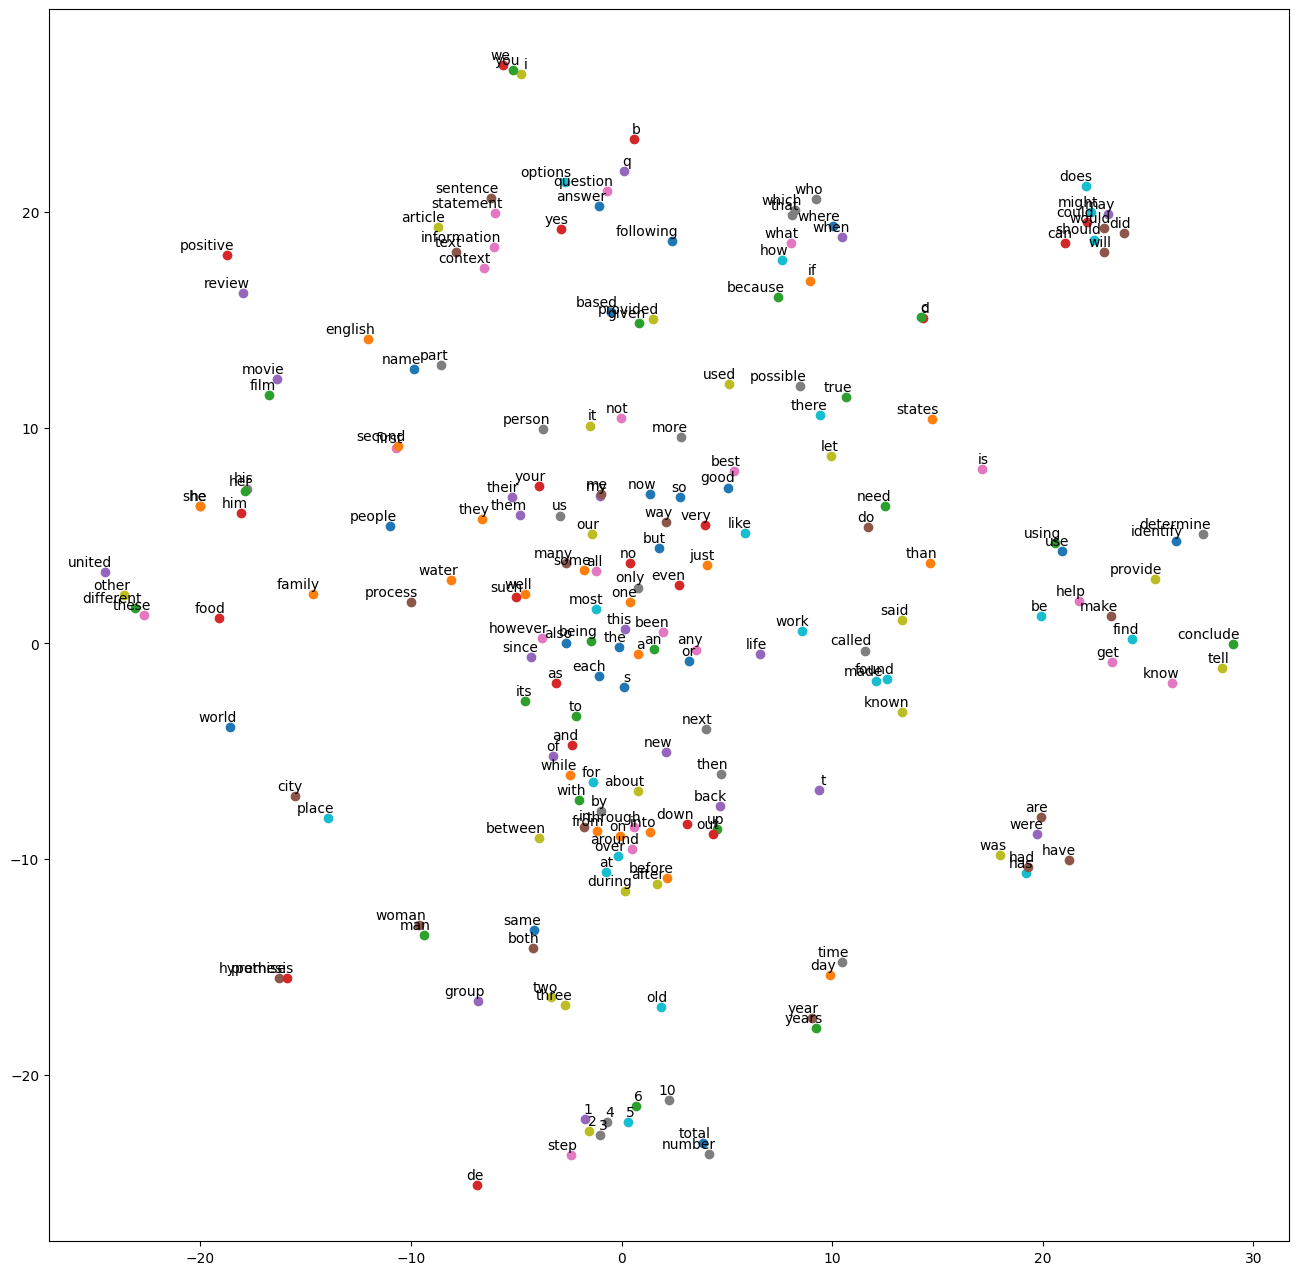

In [ ]:
words = list(model.wv.index_to_key)[:500]
word_vectors = np.array([model.wv[word] for word in words])

# Use t-SNE to reduce dimensionality
tsne = TSNE(n_components=2, random_state=0)
word_vectors_2d = tsne.fit_transform(word_vectors)

# Plotting the words in 2D space
plt.figure(figsize=(16, 16))
for i, word in enumerate(words[:200]):  # Plotting only the first 200 words for visibility
    plt.scatter(word_vectors_2d[i, 0], word_vectors_2d[i, 1])
    plt.annotate(word, xy=(word_vectors_2d[i, 0], word_vectors_2d[i, 1]), xytext=(5, 2),
                 textcoords='offset points', ha='right', va='bottom')
plt.show()

We can see that words that are semantically similar have been grouped together properly. The model is able to create an interesting embedding.

## Comparing Word embeddings

In [ ]:
result = model.wv.evaluate_word_pairs(datapath('simlex999.txt'))

In [ ]:
result = model.wv.evaluate_word_pairs(datapath('simlex999.txt'))

print(f"Pearson correlation coefficient: {result[0]}")
print(f"Spearman rank-order correlation coefficient: {result[1]}")
print(f"The ratio of pairs with unknown words: {result[2]}")

Pearson correlation coefficient: PearsonRResult(statistic=0.23799785821034994, pvalue=2.557707546287084e-14)
Spearman rank-order correlation coefficient: SignificanceResult(statistic=0.21156843957794472, pvalue=1.4593715396163838e-11)
The ratio of pairs with unknown words: 0.10010010010010009


In [ ]:
import gensim.downloader as api

model_twitter = api.load("glove-twitter-50")
model_wiki = api.load("glove-wiki-gigaword-50")

[==================================================] 100.0% 199.5/199.5MB downloaded
[==================================================] 100.0% 66.0/66.0MB downloaded


In [ ]:
print(f"Vocabulary size twitter model:   {len(model_twitter)}")
print(f"Vocabulary size wikipedia model: {len(model_wiki)}")

Vocabulary size twitter model:   1193514
Vocabulary size wikipedia model: 400000


In [ ]:
result_twitter = model_twitter.evaluate_word_pairs(datapath('simlex999.txt'))

print(f"Pearson correlation coefficient: {result_twitter[0]}")
print(f"Spearman rank-order correlation coefficient: {result_twitter[1]}")
print(f"The ratio of pairs with unknown words: {result_twitter[2]}")

Pearson correlation coefficient: PearsonRResult(statistic=0.10517458239375706, pvalue=0.000881076068771203)
Spearman rank-order correlation coefficient: SignificanceResult(statistic=0.09745772837795309, pvalue=0.002064913821243094)
The ratio of pairs with unknown words: 0.20020020020020018


In [ ]:
result_wiki = model_wiki.evaluate_word_pairs(datapath('simlex999.txt'))

print(f"Pearson correlation coefficient: {result_wiki[0]}")
print(f"Spearman rank-order correlation coefficient: {result_wiki[1]}")
print(f"The ratio of pairs with unknown words: {result_wiki[2]}")

Pearson correlation coefficient: PearsonRResult(statistic=0.2922692200209622, pvalue=4.173280537749946e-21)
Spearman rank-order correlation coefficient: SignificanceResult(statistic=0.26306011525070383, pvalue=2.932968774718573e-17)
The ratio of pairs with unknown words: 0.10010010010010009


# Classification

## Dataset preparation

The SlimOrca dataset features 13 different prompts from 'system' (listed below), that instructs the model to respond in different ways.

Now, we are going to train BERT to recognize which prompt from 'system' was given to generate each sentence in the dataset.

In [ ]:
labels = ['You are an AI assistant. You should describe the task and explain your answer. While answering a multiple choice question, first output the correct answer(s). Then explain why other answers are wrong. You might need to use additional knowledge to answer the question.',
 'You should describe the task and explain your answer. While answering a multiple choice question, first output the correct answer(s). Then explain why other answers are wrong. Think like you are answering to a five year old.',
 'User will you give you a task with some instruction. Your job is follow the instructions as faithfully as you can. While answering think step-by-step and justify your answer.',
 'You are an AI assistant. You will be given a task. You must generate a detailed and long answer.',
 'You are an AI assistant that follows instruction extremely well. Help as much as you can.',
 'Given a definition of a task and a sample input, break the definition into small parts.\nEach of those parts will have some instruction. Explain their meaning by showing an example that meets the criteria in the instruction. Use the following format:\nPart  # : a key part of the definition.\nUsage: Sample response that meets the criteria from the key part. Explain why you think it meets the criteria.',
 'You are an AI assistant. Provide a detailed answer so user don’t need to search outside to understand the answer.',
 'You are a helpful assistant, who always provide explanation. Think like you are answering to a five year old.',
 'You are a teacher. Given a task, you explain in simple steps what the task is asking, any guidelines it provides and how to use those guidelines to find the answer.',
 'You are an AI assistant. User will you give you a task. Your goal is to complete the task as faithfully as you can. While performing the task think step-by-step and justify your steps.',
 'You are an AI assistant that helps people find information. User will you give you a question. Your task is to answer as faithfully as you can. While answering think step-by-step and justify your answer.',
 'You are an AI assistant, who knows every language and how to translate one language to another. Given a task, you explain in simple steps what the task is asking, any guidelines that it provides. You solve the task and show how you used the guidelines to solve the task.',
 'Explain how you used the definition to come up with the answer.']

First, we process the SlimOrca dataset in order to obtain a list of `sentences` labeled with the prompts from `labels`.

In addition:
- Remove the redundancy of two labels that only differ on one charcater
- Only keep the conversations where a 'system' prompt is actually present

In the end, we delete the original dataset that is pretty large and not needed anymore.

In [ ]:
def get_labeled_dataset(dataset, labels):

  sentences = []
  classes = []

  for conv in dataset:
    conv = conv['conversations']

    if conv[0]['from'] == 'system':
        # Fix two classes that only differ in one character (' vs ’)
        if conv[0]['value'] == "You are an AI assistant. Provide a detailed answer so user don't need to search outside to understand the answer.":
            conv[0]['value'] = 'You are an AI assistant. Provide a detailed answer so user don’t need to search outside to understand the answer.'

        sentences.append(conv[2]['value'])
        classes.append(labels.index(conv[0]['value']))
  return sentences , classes

sentences, classes = get_labeled_dataset(dataset['train'], list(labels))
del dataset

If needed for memory limitations, we can modify the percentage of sentences that we want to keep in the dataset.

In [ ]:
perc = 1

sentences = sentences[:int(len(sentences) * perc)]
classes = classes[:int(len(classes) * perc)]

Let's explore how many sentences we have for each label.

In [ ]:
from collections import Counter

counts = Counter(classes)
for key, value in counts.items():
    if len(labels[key]) < 140:
        print("Label: " + labels[key] + "  Examples: " + str(value))
    elif "\n" in labels[key]:
        newline_idx = labels[key].index("\n")
        print("Label: " + labels[key][:newline_idx] + "(...)  Examples: " + str(value))
    else:
        print("Label: " + labels[key][:140] + "(...)  Examples: " + str(value))

Label: You are an AI assistant. You will be given a task. You must generate a detailed and long answer.  Examples: 93520
Label: You are an AI assistant that follows instruction extremely well. Help as much as you can.  Examples: 33740
Label: You are a helpful assistant, who always provide explanation. Think like you are answering to a five year old.  Examples: 71047
Label: You are an AI assistant. User will you give you a task. Your goal is to complete the task as faithfully as you can. While performing the tas(...)  Examples: 101104
Label: You are an AI assistant. Provide a detailed answer so user don’t need to search outside to understand the answer.  Examples: 33138
Label: You are a teacher. Given a task, you explain in simple steps what the task is asking, any guidelines it provides and how to use those guidel(...)  Examples: 3876
Label: Given a definition of a task and a sample input, break the definition into small parts.(...)  Examples: 4204
Label: You are an AI assistant. You s

<BarContainer object of 13 artists>

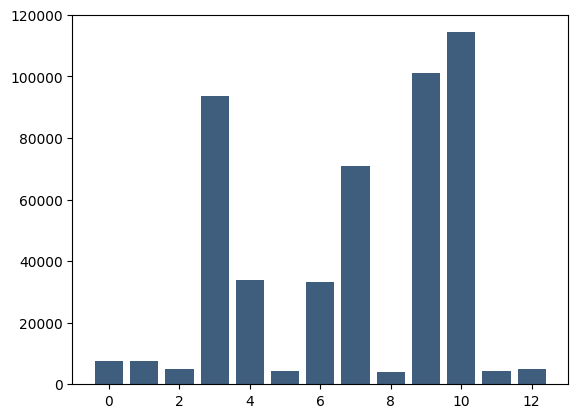

In [ ]:
import matplotlib.pyplot as plt

plt.bar(counts.keys(), counts.values(), color="#3F5D7D", width=0.8)

As we can see, there are some big differences in the number of sentences in each class.


The total number of sentences that we have is too big to be used for training using Colab resources, so we need to create a smaller sample.

But if we sample directly from `sentences`, some classes will have too few examples while others will have too many compared to our needs.

To solve this, we sample the same number of sentences from each class, equal to the minimum number of sentences in any class.


In [ ]:
from sklearn.model_selection import train_test_split

# Version of train_test_split that samples the same number of instances from each class
def uniform_train_test(data, labels, test_size, random_state):
    uniform_data = []
    uniform_labels = []
    min_label_count = min(Counter(labels).values())
    print("Minimum number of sentences in a class: " + str(min_label_count) + "\n")
    for cls in np.unique(labels):
        single_class_data = []
        single_class_labels = []
        for idx, lab in enumerate(labels):
            if lab == cls:
                single_class_data.append(data[idx])
                single_class_labels.append(cls)
        _ , single_class_data, _ , single_class_labels = train_test_split(single_class_data, single_class_labels, test_size = min_label_count - 1, random_state = seed)
        uniform_data.extend(single_class_data)
        uniform_labels.extend(single_class_labels)
    train_data, test_data, train_labels, test_labels = train_test_split(uniform_data, uniform_labels, test_size = test_size, random_state = random_state)
    return train_data, test_data, train_labels, test_labels

# Create train, validation and test sets
train_sentences, test_sentences, train_classes, test_classes = uniform_train_test(sentences, classes, test_size = 0.15, random_state = seed)
train_sentences, val_sentences, train_classes, val_classes = train_test_split(train_sentences, train_classes, test_size = len(test_sentences), random_state = seed)

print(f"Number of training sentences: {len(train_sentences)}")
print(f"Number of validation sentences: {len(val_sentences)}")
print(f"Number of testing sentences: {len(test_sentences)}")

Minimum number of sentences in a class: 3876

Number of training sentences: 35261
Number of validation sentences: 7557
Number of testing sentences: 2000


Number of sentences in each class in the training set:

<BarContainer object of 13 artists>

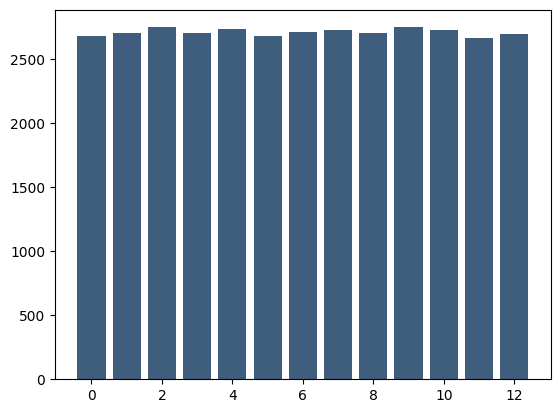

In [ ]:
train_counts = Counter(train_classes)
plt.bar(train_counts.keys(), train_counts.values(), color="#3F5D7D", width=0.8)

Number of sentences in each class in the test set (same for validation set):

<BarContainer object of 13 artists>

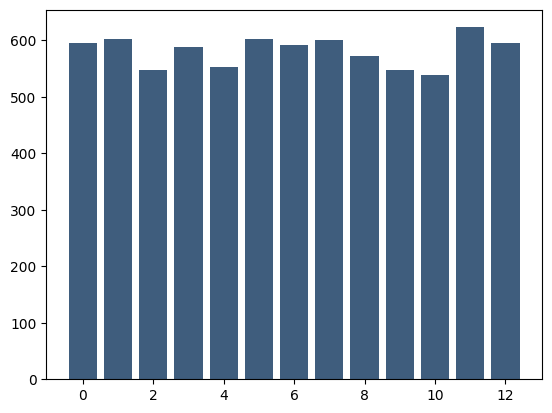

In [ ]:
test_counts = Counter(test_classes)
plt.bar(test_counts.keys(), test_counts.values(), color="#3F5D7D", width=0.8)

Now we convert the dataset to the format used in libraries by HuggingFace to ready it for tokenization and training.

In [ ]:
train_data = [{'text': txt, 'label': lbl} for txt, lbl in zip(train_sentences, train_classes)]
val_data = [{'text': txt, 'label': lbl} for txt, lbl in zip(val_sentences, val_classes)]
test_data = [{'text': txt, 'label': lbl} for txt, lbl in zip(test_sentences, test_classes)]

In [ ]:
train_data = Dataset.from_list(train_data)
validation_data = Dataset.from_list(val_data)
test_data = Dataset.from_list(test_data)

In [ ]:
data = DatasetDict()
data['train'] = train_data
data['validation'] = test_data
data['test'] = test_data

## Tokenization
Load BERT model and tokenizer.

In [ ]:
MODEL_NAME = "distilbert-base-uncased"

bert = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=len(classes))
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
bert = bert.to(device)

Tokenize traning, validation and test sets.

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding=True, truncation=True)

tokenized_data = data.map(tokenize_function, batched=True)

Map:   0%|          | 0/35261 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

## Training and evaluation
Train the model.

In [ ]:
# Training arguments
training_args = TrainingArguments(
    "bert-classification",
    eval_strategy="epoch",
    logging_strategy="epoch",
    per_device_train_batch_size=16,
    save_strategy="epoch",
    load_best_model_at_end=True,
)

In [ ]:
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    Trainer,
    TrainingArguments,
    TrainerCallback,
    TrainerState,
    TrainerControl,
)

# Define a callback to log metrics
class LogCallback(TrainerCallback):
    def __init__(self):
        self.log_history = []

    def on_log(self, args: TrainingArguments, state: TrainerState, control: TrainerControl, **kwargs):
        self.log_history.append(state.log_history[-1])

# Instantiate the callback
log_callback = LogCallback()

Epoch,Training Loss,Validation Loss
1,1.361700,0.689013
2,0.590300,0.639495
3,0.388500,0.694023


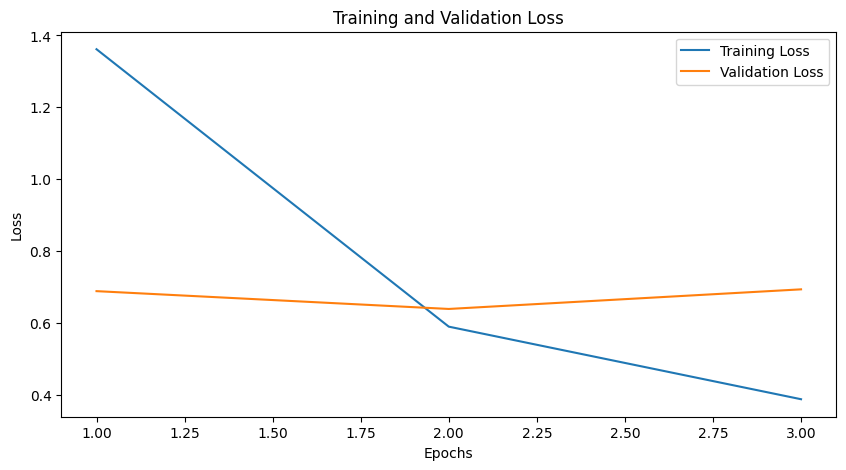

In [ ]:
# Trainer
trainer = Trainer(
    model=bert,
    args=training_args,
    train_dataset=tokenized_data['train'],
    eval_dataset=tokenized_data['validation'],
    callbacks=[log_callback]
)

# Train the model
trainer.train()

# Extract logged metrics
logs = log_callback.log_history

# Separate metrics for plotting
train_loss = [log['loss'] for log in logs if 'loss' in log]
eval_loss = [log['eval_loss'] for log in logs if 'eval_loss' in log]
steps = range(1, len(train_loss) + 1)

# Plot the learning curve
plt.figure(figsize=(10, 5))
plt.plot(steps, train_loss, label='Training Loss')
plt.plot(steps, eval_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
trainer.evaluate()

Compute performance metrics for the trained model.

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

preds = trainer.predict(tokenized_data['test'])
y_pred = torch.argmax(torch.tensor(preds.predictions), dim=1).numpy()

target_names = ["Label " + str(num) for num in range (len(labels))]
print(classification_report(test_classes, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     Label 0       0.89      0.91      0.90       149
     Label 1       0.91      0.93      0.92       148
     Label 2       0.57      0.67      0.61       128
     Label 3       0.76      0.70      0.73       150
     Label 4       0.51      0.56      0.53       159
     Label 5       1.00      1.00      1.00       176
     Label 6       0.50      0.55      0.53       154
     Label 7       0.86      0.86      0.86       177
     Label 8       0.90      0.89      0.90       170
     Label 9       0.68      0.61      0.65       124
    Label 10       0.96      0.94      0.95       151
    Label 11       0.89      0.84      0.86       164
    Label 12       0.86      0.73      0.79       150

    accuracy                           0.79      2000
   macro avg       0.79      0.78      0.79      2000
weighted avg       0.80      0.79      0.79      2000



Print confusion matrix.

In [ ]:
print(confusion_matrix(test_classes, y_pred))

[[136  11   0   1   0   0   0   0   0   0   0   0   1]
 [ 10 138   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0  86   2   6   0   8   2   1   8   0   7   8]
 [  3   0   0 105   6   0  22   5   0   8   1   0   0]
 [  0   0  11   4  89   0  36   9   0   6   1   0   3]
 [  0   0   0   0   0 176   0   0   0   0   0   0   0]
 [  2   0  11   7  37   0  85   3   1   4   0   0   4]
 [  0   3   1   5  10   0   1 153   0   4   0   0   0]
 [  0   0   9   0   0   0   0   0 151   0   0  10   0]
 [  1   0   8  11  13   0  10   3   0  76   2   0   0]
 [  0   0   1   1   0   0   5   0   0   2 142   0   0]
 [  0   0   6   0   3   0   0   1  14   1   0 137   2]
 [  1   0  19   2  10   0   2   2   0   2   2   0 110]]


Save the model.

In [ ]:
bert.save_pretrained('./Models/Bert_Classification')